In [5]:
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

tf.random.set_seed(1234)

In [77]:
# DATA_DIR = tf.keras.utils.get_file(
#     "ModelNet.zip",
#     "https://modelnet.cs.princeton.edu/ModelNet40.zip",
#     extract=True,
# )
## Download the data from https://modelnet.cs.princeton.edu/ModelNet40.zip and extract it to a folder
# Notebook based on https://keras.io/examples/vision/pointnet/
# LiDAR Dataset + Image Dataset coming soon
DATA_DIR = "/Users/Tim/Downloads/ModelNet40"


In [78]:
mesh = trimesh.load(os.path.join(DATA_DIR, "airplane/train/airplane_0001.off"))


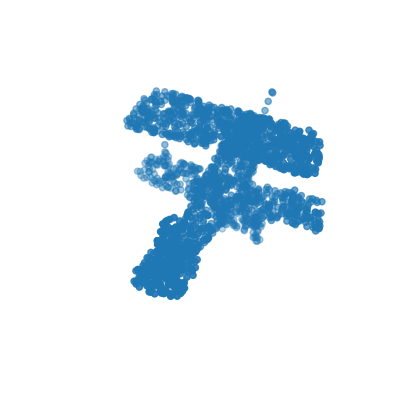

In [79]:
points = mesh.sample(2048)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

In [80]:
def parse_dataset(num_points=2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [81]:
NUM_POINTS = 2048
NUM_CLASSES = 40
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(
    NUM_POINTS
)


processing class: lamp
processing class: wardrobe
processing class: bench
processing class: piano
processing class: car
processing class: bed
processing class: monitor
processing class: cup
processing class: radio
processing class: mantel
processing class: desk
processing class: plant
processing class: xbox
processing class: curtain
processing class: person
processing class: stool
processing class: range_hood
processing class: guitar
processing class: chair
processing class: sink
processing class: bookshelf
processing class: dresser
processing class: cone
processing class: vase
processing class: glass_box
processing class: tent
processing class: toilet
processing class: sofa
processing class: bowl
processing class: table
processing class: flower_pot
processing class: airplane
processing class: night_stand
processing class: bathtub
processing class: tv_stand
processing class: laptop
processing class: stairs
processing class: bottle
processing class: keyboard
processing class: door


In [82]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

In [83]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [84]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

In [85]:
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [86]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 2048, 3)]    0           []                               
                                                                                                  
 conv1d_11 (Conv1D)             (None, 2048, 32)     128         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_17 (BatchN  (None, 2048, 32)    128         ['conv1d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_17 (Activation)     (None, 2048, 32)     0           ['batch_normalization_17[0

In [87]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=20, validation_data=test_dataset)


Epoch 1/20


2023-02-26 12:51:24.056377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


308/308 [==============================] - ETA: 0s - loss: 4.7385 - sparse_categorical_accuracy: 0.1181

2023-02-26 12:51:59.746162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


308/308 [==============================] - 40s 119ms/step - loss: 4.7385 - sparse_categorical_accuracy: 0.1181 - val_loss: 7375195053952825045286912.0000 - val_sparse_categorical_accuracy: 0.1163
Epoch 2/20
308/308 [==============================] - 33s 104ms/step - loss: 4.3774 - sparse_categorical_accuracy: 0.1772 - val_loss: 51513811848128096108544.0000 - val_sparse_categorical_accuracy: 0.1191
Epoch 3/20
308/308 [==============================] - 32s 104ms/step - loss: 4.1404 - sparse_categorical_accuracy: 0.2029 - val_loss: 65497927233630801017962496.0000 - val_sparse_categorical_accuracy: 0.1130
Epoch 4/20
308/308 [==============================] - 32s 104ms/step - loss: 4.0930 - sparse_categorical_accuracy: 0.2076 - val_loss: 60143649986492086878208.0000 - val_sparse_categorical_accuracy: 0.1665
Epoch 5/20
308/308 [==============================] - 33s 106ms/step - loss: 3.9328 - sparse_categorical_accuracy: 0.2249 - val_loss: 6650651136.0000 - val_sparse_categorical_accuracy: 0

In [88]:
import glob
LABELS = ["bowl", "car", "bottle"]
bowl_dir = glob.glob("/Users/Tim/Downloads/bowls/*")

In [ ]:
SIFT_COUNTER = 0
BRISK_COUNTER = 0
COLMAP_COUNTER = 0
ORB_COUNTER = 0
for i in bowl_dir:
    if "SIFT" in i:
        for files in glob.glob(i + "/*"):
            mesh = trimesh.load(files)
            pred = model.predict(mesh.sample(2048).reshape(1, 2048, 3))
            print("Prediction")
            prediction = np.argmax(pred)
            print(CLASS_MAP[prediction])
            if CLASS_MAP[prediction] == "bowl":
                SIFT_COUNTER += 1
    if "BRISK" in i:
        for files in glob.glob(i + "/*"):
            mesh = trimesh.load(files)
            pred = model.predict(mesh.sample(2048).reshape(1, 2048, 3))
            print("Prediction")
            prediction = np.argmax(pred)
            print(CLASS_MAP[prediction])
            if CLASS_MAP[prediction] == "bowl":
                BRISK_COUNTER += 1
    if "COLMAP" in i:
        for files in glob.glob(i + "/*"):
            mesh = trimesh.load(files)
            pred = model.predict(mesh.sample(2048).reshape(1, 2048, 3))
            print("Prediction")
            prediction = np.argmax(pred)
            print(CLASS_MAP[prediction])
            if CLASS_MAP[prediction] == "bowl":
                COLMAP_COUNTER += 1
    if "ORB" in i:
        for files in glob.glob(i + "/*"):
            mesh = trimesh.load(files)
            pred = model.predict(mesh.sample(2048).reshape(1, 2048, 3))
            print("Prediction")
            prediction = np.argmax(pred)
            print(CLASS_MAP[prediction])
            if CLASS_MAP[prediction] == "bowl":
                ORB_COUNTER += 1
print("SIFT: ", SIFT_COUNTER)
print("BRISK: ", BRISK_COUNTER)
print("COLMAP: ", COLMAP_COUNTER)
print("ORB: ", ORB_COUNTER)

1/1 [==============================] - 0s 44ms/step
Prediction
airplane
1/1 [==============================] - 0s 15ms/step
Prediction
chair
1/1 [==============================] - 0s 14ms/step
Prediction
mantel
1/1 [==============================] - 0s 13ms/step
Prediction
mantel
1/1 [==============================] - 0s 15ms/step
Prediction
bottle
1/1 [==============================] - 0s 13ms/step
Prediction
bottle
1/1 [==============================] - 0s 16ms/step
Prediction
vase
1/1 [==============================] - 0s 14ms/step
Prediction
bottle
1/1 [==============================] - 0s 15ms/step
Prediction
car
1/1 [==============================] - 0s 15ms/step


In [102]:
bottle_dir = glob.glob("/Users/Tim/Downloads/bottles/*")
for j in bottle_dir:
    if "SIFT" in i:
        for files in glob.glob(i + "/*"):
            mesh = trimesh.load(files)
            pred = model.predict(mesh.sample(2048).reshape(1, 2048, 3))
            print("Prediction")
            prediction = np.argmax(pred)
            print(CLASS_MAP[prediction])
            if CLASS_MAP[prediction] == "bottle":
                SIFT_COUNTER += 1
    if "BRISK" in i:
        for files in glob.glob(i + "/*"):
            mesh = trimesh.load(files)
            pred = model.predict(mesh.sample(2048).reshape(1, 2048, 3))
            print("Prediction")
            prediction = np.argmax(pred)
            print(CLASS_MAP[prediction])
            if CLASS_MAP[prediction] == "bottle":
                BRISK_COUNTER += 1
    if "COLMAP" in i:
        for files in glob.glob(i + "/*"):
            mesh = trimesh.load(files)
            pred = model.predict(mesh.sample(2048).reshape(1, 2048, 3))
            print("Prediction")
            prediction = np.argmax(pred)
            print(CLASS_MAP[prediction])
            if CLASS_MAP[prediction] == "bottle":
                COLMAP_COUNTER += 1
    if "ORB" in i:
        for files in glob.glob(i + "/*"):
            mesh = trimesh.load(files)
            pred = model.predict(mesh.sample(2048).reshape(1, 2048, 3))
            print("Prediction")
            prediction = np.argmax(pred)
            print(CLASS_MAP[prediction])
            if CLASS_MAP[prediction] == "bottle":
                ORB_COUNTER += 1
print("SIFT: ", SIFT_COUNTER)
print("BRISK: ", BRISK_COUNTER)
print("COLMAP: ", COLMAP_COUNTER)
print("ORB: ", ORB_COUNTER)

1/1 [==============================] - 0s 22ms/step
Prediction
airplane
1/1 [==============================] - 0s 13ms/step
Prediction
mantel
1/1 [==============================] - 0s 13ms/step
Prediction
car
1/1 [==============================] - 0s 13ms/step
Prediction
mantel
1/1 [==============================] - 0s 13ms/step
Prediction
mantel
1/1 [==============================] - 0s 14ms/step
Prediction
airplane
1/1 [==============================] - 0s 14ms/step
Prediction
mantel
1/1 [==============================] - 0s 13ms/step
Prediction
car
1/1 [==============================] - 0s 14ms/step
Prediction
mantel
1/1 [==============================] - 0s 15ms/step
Prediction
mantel
1/1 [==============================] - 0s 14ms/step
Prediction
airplane
1/1 [==============================] - 0s 15ms/step
Prediction
mantel
1/1 [==============================] - 0s 14ms/step
Prediction
car
1/1 [==============================] - 0s 14ms/step
Prediction
mantel
1/1 [==================

In [101]:
car_dir = glob.glob("/Users/Tim/Downloads/cars/*")
for j in car_dir:
    if "SIFT" in i:
        for files in glob.glob(i + "/*"):
            try:
                mesh = trimesh.load(files)
                pred = model.predict(mesh.sample(2048).reshape(1, 2048, 3))
                print("Prediction")
                prediction = np.argmax(pred)
                if CLASS_MAP[prediction] == "car":
                    SIFT_COUNTER += 1
            except:
                print("Error")
    if "BRISK" in i:
        for files in glob.glob(i + "/*"):
            mesh = trimesh.load(files)
            pred = model.predict(mesh.sample(2048).reshape(1, 2048, 3))
            print("Prediction")
            prediction = np.argmax(pred)
            print(CLASS_MAP[prediction])
            if CLASS_MAP[prediction] == "car":
                BRISK_COUNTER += 1
    if "COLMAP" in i:
        for files in glob.glob(i + "/*"):
            mesh = trimesh.load(files)
            pred = model.predict(mesh.sample(2048).reshape(1, 2048, 3))
            print("Prediction")
            prediction = np.argmax(pred)
            print(CLASS_MAP[prediction])
            if CLASS_MAP[prediction] == "car":
                COLMAP_COUNTER += 1
    if "ORB" in i:
        for files in glob.glob(i + "/*"):
            mesh = trimesh.load(files)
            pred = model.predict(mesh.sample(2048).reshape(1, 2048, 3))
            print("Prediction")
            prediction = np.argmax(pred)
            print(CLASS_MAP[prediction])
            if CLASS_MAP[prediction] == "car":
                ORB_COUNTER += 1
print("SIFT: ", SIFT_COUNTER)
print("BRISK: ", BRISK_COUNTER)
print("COLMAP: ", COLMAP_COUNTER)
print("ORB: ", ORB_COUNTER)

1/1 [==============================] - 0s 14ms/step
Prediction
airplane
1/1 [==============================] - 0s 14ms/step
Prediction
mantel
1/1 [==============================] - 0s 14ms/step
Prediction
car
1/1 [==============================] - 0s 14ms/step
Prediction
mantel
1/1 [==============================] - 0s 14ms/step
Prediction
mantel
1/1 [==============================] - 0s 13ms/step
Prediction
airplane
1/1 [==============================] - 0s 13ms/step
Prediction
mantel
1/1 [==============================] - 0s 14ms/step
Prediction
car
1/1 [==============================] - 0s 15ms/step
Prediction
mantel
1/1 [==============================] - 0s 14ms/step
Prediction
mantel
1/1 [==============================] - 0s 14ms/step
Prediction
airplane
1/1 [==============================] - 0s 13ms/step
Prediction
mantel
1/1 [==============================] - 0s 15ms/step
Prediction
car
1/1 [==============================] - 0s 15ms/step
Prediction
mantel
1/1 [==================